In [8]:
import ares
import numpy as np
import random
import matplotlib.pyplot as pl
from numpy.linalg import inv
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [9]:
blobs_scalar = [ 'z_D', 'dTb_D', 'tau_e']
blobs_1d = ['igm_Tk', 'dTb']
blobs_1d_z = np.arange(6,16)


In [10]:
base_pars = \
{
    'problem_type': 101,
    'tanh_model': True,
    'blob_names': [blobs_scalar, blobs_1d],
    'blob_ivars': [None, [('z', blobs_1d_z)]],
    'blob_funcs': None,
}

In [11]:

mg = ares.inference.ModelGrid(**base_pars)

In [12]:
z0 = np.arange(6,7.5,0.5)
dz = np.arange(1,2.5, 0.5)
#how is arange different than linspace

In [13]:
mg.axes = {'tanh_xz0' : z0, 'tanh_xdz' : dz}


In [14]:
mg.run('Fisher_run', clobber = True, save_freq = 100)

Starting 9-element model grid.
Running 9-element model grid.
Processor 0: Wrote Fisher_run.*.pkl (Fri Nov 30 18:05:25 2018)
Calculation complete: Fri Nov 30 18:05:25 2018
Elapsed time (min)  : 0.0164


In [15]:
anl = ares.analysis.ModelSet('Fisher_run')


##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Basic Information                                                                                    ####
#### ---------------------------------------------------------------------------------------------------- ####
#### path        : ./                                                                                     ####
#### prefix      : Fisher_run                                                                             ####
#### N-d         : 2                                                                                      ####


In [16]:
mg.axes = {'tanh_xz0' : z0, 'tanh_xdz' : dz}


Masking 0 elements in (tanh_xz0, tanh_xdz) plane.


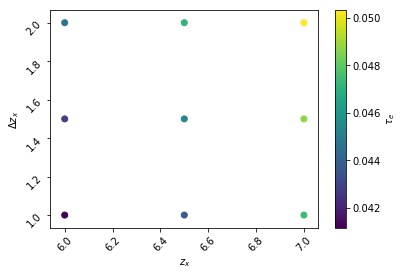

In [17]:
ax1 = anl.Scatter(anl.parameters, c = 'tau_e', fig =1)

Masking 0 elements in (z_D, dTb_D) plane.


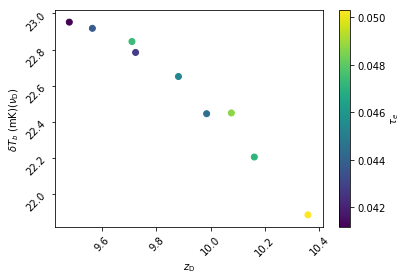

In [18]:
ax2 = anl.Scatter( [ 'z_D', 'dTb_D'], c ='tau_e', fig = 2)

[6.0]


Text(0,0.5,'tanh_xdz')

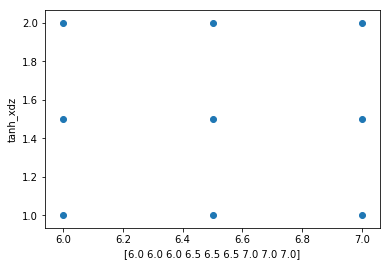

In [19]:
print anl.chain[0,:1]
#what is the difference between the first and the second dimension of chain? get_glob has obvious first and second
#this just shows which parameters were used

xdata, ydata = anl.chain[:,0], anl.chain[:,1]
pl.scatter(xdata, ydata)
pl.xlabel(anl.chain[:,0])
pl.ylabel(anl.parameters[1])

In [20]:
anl.get_blob('dTb').shape

(9, 10)

In [21]:
pars = anl.chain[8,:]
dTb1 = anl.get_blob('dTb')[4,:]
print dTb1
print pars

[7.9335783846143935 14.323173514959354 19.792616421616184
 22.136640067241977 22.642042263212783 21.865746339501733
 19.529731878926256 14.781004018390481 6.2878944543168975
 -7.538147471467333]
[7.0 2.0]


In [36]:
dTbda = []
dTbdb = []

for i in range(0,10):
    dTb_zi = anl.get_blob('dTb')[:,i]
    dxz0 = (dTb_zi[2]- dTb_zi[0])/(2*0.5)
    dxdz = (dTb_zi[5]-dTb_zi[3])/(2*0.5)
    dTbda.append(dxz0)
    dTbdb.append(dxdz)
    
ab = np.dot(dTbda, dTbdb)
dTbda_square = np.square(dTbda)
dTbdb_square = np.square(dTbdb)
aa = np.sum(dTbda_square)
bb = np.sum(dTbdb_square)

F = np.matrix([[aa,ab], [ab, bb]])
print "Fisher Matrix:"
print F




Fisher Matrix:
[[17.45260075 15.23164519]
 [15.23164519 20.78822517]]


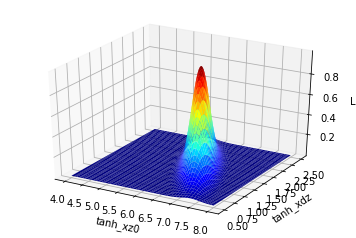

In [16]:
x = np.linspace(4,8, 1000)
y = np.linspace(0.5, 2.5, 1000)
X,Y = np.meshgrid(x,y)
Z = np.exp(-0.5*(aa*(X-6.5)**2 + 2*ab*(X-6.5)*(Y-1.5) + bb*(Y-1.5)**2))
fig = pl.figure()
ax = fig.gca(projection = '3d')
surf = ax.plot_surface(X,Y,Z , cmap = cm.jet , linewidth = 0, antialiased = True)
ax.set_xlabel(anl.parameters[0])
ax.set_ylabel(anl.parameters[1])
ax.set_zlabel('L')
pl.show()


Text(0,0.5,'$\\Delta_z$')

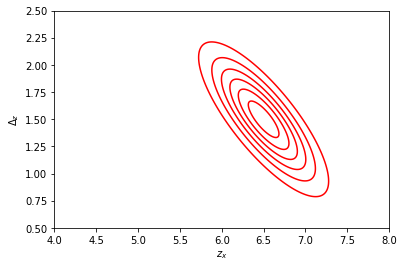

In [63]:
pl.contour(X, Y, Z, colors = 'red');
pl.xlabel(r'$z_x$')
pl.ylabel(r'$\Delta_z$')

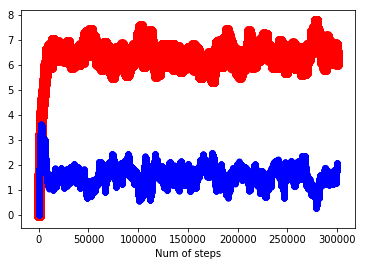

In [64]:
def Metropolis_algorithm(walks, starting_point):
    collect_result = []
    collect_xresult = []
    collect_yresult = []
    
    #def L
    #def L(parameter_array):
        #return np.exp(-0.5*(aa*(parameter_array[0] - 6.5)**2 + 2*ab*(parameter_array[0]-6.5)*(parameter_array[1]-1.5) + bb*(parameter_array[1] - 1.5)**2 ))
    
    
    def L(parameter_array):
        return np.exp(-0.5*(aa*(parameter_array[0]-6.5)**2 + 2*ab*(parameter_array[0]-6.5)*(parameter_array[1]-1.5)+bb*(parameter_array[1]-1.5)**2))
   

    for i in range(1, walks-1):
        
        #proposal distribution for parameter space
        dr = []
        dr = [random.gauss(0, 0.01), random.gauss(0,0.01)]
        rstar = np.add(starting_point, dr)
        
        #metropolis condition
        l = L(rstar)/L(starting_point)
        
        #draw a random number between 0 and 1
        u = np.random.uniform(0,1)
        
        #run mcmc
        if u < min(1, l):
            starting_point = rstar
            collect_result = rstar
            collect_xresult.append(rstar[0])
            collect_yresult.append(rstar[1])
        else:
            collect_result = starting_point
            collect_xresult.append(starting_point[0])
            collect_yresult.append(starting_point[1])
          
    pl.scatter(range(i), collect_xresult, color = 'red', linewidths = 5.01)
    pl.scatter(range(i), collect_yresult, color = 'blue' , linewidths = 0.01)
    pl.xlabel('Num of steps')
           
    return collect_result
Metropolis_algorithm(300000, [0,0])
walkers = 80
#for i in range(1, walkers):
    #final_position = []
    #final_position = Metropolis_algorithm(30, [0,0])
    #pl.scatter(final_position[0], final_position[1])
    #pl.xlabel(r'$Z_D$')
    #pl.ylabel(r'$\Delta_x$')

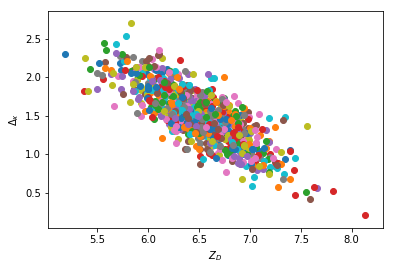

In [65]:
def Metropolis_algorithm(walks, starting_point):
    collect_result = []
    collect_xresult = []
    collect_yresult = []
    
    #def L
    #def L(parameter_array):
        #return np.exp(-0.5*(aa*(parameter_array[0] - 6.5)**2 + 2*ab*(parameter_array[0]-6.5)*(parameter_array[1]-1.5) + bb*(parameter_array[1] - 1.5)**2 ))
    
    
    def L(parameter_array):
        return np.exp(-0.5*(aa*(parameter_array[0]-6.5)**2 + 2*ab*(parameter_array[0]-6.5)*(parameter_array[1]-1.5)+bb*(parameter_array[1]-1.5)**2))
   

    for i in range(1, walks-1):
        
        #proposal distribution for parameter space
        dr = []
        dr = [random.gauss(0, 0.01), random.gauss(0,0.01)]
        rstar = np.add(starting_point, dr)
        
        #metropolis condition
        l = L(rstar)/L(starting_point)
        
        #draw a random number between 0 and 1
        u = np.random.uniform(0,1)
        
        #run mcmc
        if u < min(1, l):
            starting_point = rstar
            collect_result = rstar
            collect_xresult.append(rstar[0])
            collect_yresult.append(rstar[1])
        else:
            collect_result = starting_point
            collect_xresult.append(starting_point[0])
            collect_yresult.append(starting_point[1])
          
    #pl.scatter(range(i), collect_xresult, color = 'red', linewidths = 0.01)
    #pl.scatter(range(i), collect_yresult, color = 'blue' , linewidths = 0.01)
    #pl.xlabel('Num of steps')
           
    return collect_result

walkers = 800
for i in range(1, walkers):
    final_position = []
    final_position = Metropolis_algorithm(30000, [0,0])
    pl.scatter(final_position[0], final_position[1])
    pl.xlabel(r'$Z_D$')
    pl.ylabel(r'$\Delta_x$')

In [17]:
def f(x):
    return np.exp(-x**2)

def g(x,y):
    return x**2+2*(y)**2

sample_end  = 10 
sample_start = 0
Nf = 10
d = []
for i in range(1, Nf):
    
    y = f(sample_start)
    d.append(y)
    sample_start = sample_start + (sample_end/Nf)
    #i = i + Nf
    
print d  
#need a float number?
#something that doesn't round to zero each iteration

[1.0, 0.36787944117144233, 0.01831563888873418, 0.00012340980408667956, 1.1253517471925912e-07, 1.3887943864964021e-11, 2.3195228302435696e-16, 5.242885663363464e-22, 1.603810890548638e-28]


In [53]:
x = np.linspace(-3, 3, 3)
y = np.linspace(-3,3, 3)
X, Y = np.meshgrid(x, y, indexing = 'ij')
d_array = []
d_array = g(X,Y)
d_array[2][1]

9.0

In [19]:
#define chi squar
model = anl.get_blob('dTb')[:,0]
print model[8]
print model

6.172936333165895
[11.81981351340893 11.34884474843941 11.111748659903219 6.786892325484477
 7.9335783846143935 8.533970208478848 3.145786772362319 5.001809515557458
 6.172936333165895]


In [59]:
#define chi squared
chi = [[0]*3 for _ in range(3)]
chi[0][0] = d_array[0][0] - model[0]
chi[0][1] = d_array[0][1] - model[1]
chi[0][2]= d_array[0][2] - model[2]

chi[1][0] = d_array[1][0] - model[3]
chi[1][1] = d_array[1][1] - model[4]
chi[1][2]= d_array[1][2] - model[5]

chi[2][0] = d_array[1][0] - model[6]
chi[2][1] = d_array[1][1] - model[7]
chi[2][2]= d_array[1][2] - model[8]

print chi

[[15.18018648659107, -2.3488447484394097, 15.888251340096781], [11.213107674515523, -7.9335783846143935, 9.466029791521152], [14.85421322763768, -5.001809515557458, 11.827063666834105]]


In [54]:
dTb_all_z = []
for i in range(0,10):
    dTb_all_z.append(anl.get_blob('dTb')[:,i])
    
print dTb_all_z[9][0]
#dtt = anl.chain[0:]
#print dtt
    

-7.538236535129804


In [48]:
dTb0 = anl.get_blob('dTb')
shapeT = dTb0.shape
print dTb0
print shapeT

[[11.81981351340893 19.092086629911 22.067531474336825 22.869757763056974
  22.8474382619248 21.919073540395903 19.542411400944694
  14.783555002656849 6.2881839657149845 -7.538236535129804]
 [11.34884474843941 17.154784127197946 21.011600716132616
  22.514041130555057 22.745220922753273 21.892147342084005
  19.535958224522602 14.782251234791646 6.2880356762278025
  -7.538190863188516]
 [11.111748659903219 15.847326274705877 19.792935162910506
  21.839071559596483 22.443873412223525 21.77316892882936
  19.494121474563563 14.770039600824012 6.286051152296827
  -7.537315466753015]
 [6.786892325484477 15.845930949489327 21.405476185815896
  22.772965655779227 22.834258151671506 21.91735497237461
  19.54220371510051 14.783533591864455 6.288182715653633
  -7.538236340433295]
 [7.9335783846143935 14.323173514959354 19.792616421616184
  22.136640067241977 22.642042263212783 21.865746339501733
  19.529731878926256 14.781004018390481 6.2878944543168975
  -7.538147471467333]
 [8.533970208478848 

In [49]:
z0 = anl.get_ivars('dTb')
print z0

[array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15])]
